# Load libraries needed

In [ ]:
#Pandas
import pandas as pd
from pandas import ExcelWriter, ExcelFile

#Numpy
import numpy as np

#NLTK
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop = stopwords.words('english')
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

#SkLearn
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

#Other
import string
import seaborn as sns
import yellowbrick as yb
from yellowbrick.classifier import ClassificationReport


df = pd.read_excel('list_project_updated.xlsx')

In [360]:
#Check to make sure we have the columns and it imported 
print(df.columns)

#The categorical variables needed to one hot encode
cat_var = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['object']] 

#Do not want to hot encode these.  
cat_var.remove('CHD_OTHSP')
cat_var.remove('SPECOTH')

#show the categorical
print(cat_var)

Index(['Unnamed: 0', 'AGE_LISTING', 'AGE_TXPL', 'STATLIST', 'SLVAD', 'SLECMO',
       'SLVENT', 'HXARRYTH', 'HXCPR', 'HXDIAB',
       ...
       'LS_SURG_TRUNCUS', 'LS_SURG_VALVE', 'LS_SURG_VSD', 'LS_SURG_OTHER',
       'GRAFT_LOSS', 'INT_GRAFT_LOSS', 'LSNYHA_T', 'LSRHFCL_T', 'PATIENT_ID',
       'HETEROTAXY'],
      dtype='object', length=226)
['STATLIST', 'SLINODS', 'SEX', 'TXSTAT', 'DONORSEX', 'STATUS_LISTING', 'STATUS_TXPL', 'LSNYHA_T', 'LSRHFCL_T']


# Prepare Data 

In [361]:
#This unnamed column gets added as an index from importing with pandas, not sure how to drop it in the 
#import so just dropping it here
df.drop(df.filter(regex="Unname"),axis=1, inplace=True)

#Looking at the data specs
print(df.shape)
print(df.head())
print(df.describe())

(9204, 225)
   AGE_LISTING   AGE_TXPL STATLIST  SLVAD  SLECMO  SLVENT  HXARRYTH  HXCPR  \
0    15.855219  16.046873        1    0.0     0.0     0.0       1.0    NaN   
1     5.065128   5.100721        1    0.0     0.0     0.0       0.0    NaN   
2     9.089851   9.278767        2    0.0     0.0     0.0       0.0    NaN   
3     0.722807   1.136231        2    0.0     0.0     0.0       0.0    NaN   
4     0.032855        NaN        1    0.0     0.0     1.0       1.0    NaN   

   HXDIAB  HXGI  ...  LS_SURG_TRUNCUS  LS_SURG_VALVE  LS_SURG_VSD  \
0     0.0   0.0  ...                0              0            0   
1     0.0   0.0  ...                0              0            0   
2     0.0   0.0  ...                0              0            0   
3     0.0   0.0  ...                0              0            0   
4     0.0   0.0  ...                0              0            0   

   LS_SURG_OTHER  GRAFT_LOSS  INT_GRAFT_LOSS  LSNYHA_T  LSRHFCL_T  PATIENT_ID  \
0              0       

In [396]:
#One hot encode everything
df_processed = pd.get_dummies(df, prefix_sep="_",columns=cat_var)

#Text variables to drop from the first model
text = [key for key in dict(df_processed.dtypes) if dict(df_processed.dtypes)[key] in ['object']] 

#These are the text variables now because we transformed the others
print(text)

#Storing all continuous variables
con_var = [key for key in dict(df_processed.dtypes) if dict(df_processed.dtypes)[key] not in ['object']] 

#We don't want this in any of the models, it's useless information
con_var.remove('PATIENT_ID')

#Look at how many people are flagged as Heterotaxy to ensure it was the amount Tobias thought
df_processed['HETEROTAXY'].value_counts()

#Look at the data
df_processed


['SPECOTH', 'CHD_OTHSP']


,AGE_LISTING,AGE_TXPL,SLVAD,SLECMO,SLVENT,HXARRYTH,HXCPR,HXDIAB,HXGI,HXISO,...,LSNYHA_T_NYHA_4,LSNYHA_T_Not_Done,LSNYHA_T_Unknown,LSRHFCL_T_.,LSRHFCL_T_Not_Done,LSRHFCL_T_Ross_1,LSRHFCL_T_Ross_2,LSRHFCL_T_Ross_3,LSRHFCL_T_Ross_4,LSRHFCL_T_Unknown
0,15.855219,16.046873,0.0,0.0,0.0,1.0,NaN,0.0,0.0,NaN,...,0,0,0,1,0,0,0,0,0,0
1,5.065128,5.100721,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,...,0,0,0,1,0,0,0,0,0,0
2,9.089851,9.278767,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,...,0,0,0,1,0,0,0,0,0,0
3,0.722807,1.136231,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,...,0,0,0,1,0,0,0,0,0,0
4,0.032855,NaN,0.0,0.0,1.0,1.0,NaN,0.0,0.0,NaN,...,0,0,0,1,0,0,0,0,0,0
5,12.386291,NaN,0.0,0.0,0.0,1.0,NaN,0.0,0.0,NaN,...,0,0,0,1,0,0,0,0,0,0
6,3.980917,4.115074,0.0,0.0,0.0,0.0,NaN,0.0,1.0,NaN,...,0,0,0,1,0,0,0,0,0,0
7,0.147847,0.446279,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,...,0,0,0,1,0,0,0,0,0,0
8,4.892640,5.097983,0.0,0.0,0.0,1.0,NaN,0.0,1.0,NaN,...,0,0,0,1,0,0,0,0,0,0
9,10.609390,10.749023,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,...,0,0,0,1,0,0,0,0,0,0


In [397]:
#Model without text fields
#Drop the text fields
df_model1 = df_processed.drop(text,axis=1)


In [364]:
df_model1

#Look at missing
def missing(dff):
    print (round((dff.isnull().sum() * 100/ len(dff)),2).sort_values(ascending=False))

#This is an issue
missing(df_model1)


CHD_USPL                     99.10
TXVLDL_R                     98.72
CHD_UNK                      98.39
TXCSTAT                      97.12
LVLDL_R                      96.41
TXPALB_R                     96.31
LSCSTAT                      95.82
TXEDP                        95.58
TXPBNP_R                     95.28
LSPALB_R                     94.43
TXLDL_R                      94.15
TXHDL_R                      94.06
TXBRS                        93.21
LSPBNP_R                     92.88
TXBCO                        92.67
TXSVCSAT                     92.58
TXBAOSAT                     92.10
TXBRP                        91.57
TXCHOL_R                     91.49
TXBCI                        91.25
TXTG_R                       90.00
TXBPCW                       89.95
TXBRAM                       89.86
TXBPAM                       89.44
TXCRP_R                      87.20
TXBNP                        86.33
TXEPINE                      85.21
TXVASOPR                     85.21
TXSILDEN            

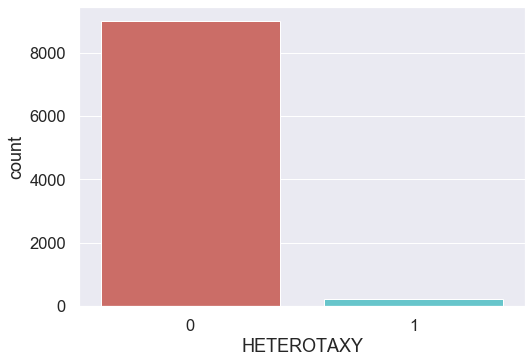

In [428]:
#Impute with the median, I just randomly chose this...could do whatever.
df_imp = df_model1.fillna(df_model1.median())

df_imp

#Huge class imbalacnce
sns.set(font_scale=1.5)
countplt=sns.countplot(x='HETEROTAXY', data=df_imp, palette ='hls')
plt.show()


# Prepare Data with Test Train Split

In [429]:
#Everything but the predictor
cols = [col for col in df_imp.columns if col not in ['HETEROTAXY']]

#The data with all columns but target
data = df_imp[cols]

#The predictor
target = df_imp['HETEROTAXY']

#Split the data
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20)

#Print dimensions
print(data_train.shape)
print(data_test.shape)
print(target_train.shape)
print(target_test.shape)


(7363, 247)
(1841, 247)
(7363,)
(1841,)


# Niave Bayes - NEED TO UPDATE

In [430]:

#create an object of the type GaussianNB
gnb = GaussianNB()

#train the algorithm on training data and predict using the testing data
pred = gnb.fit(data_train, target_train).predict(data_test)

#print the accuracy score of the model
print("Naive-Bayes accuracy : ",accuracy_score(target_test, pred, normalize = True))

#NEED TO FIX!!!


Naive-Bayes accuracy :  0.23411189570885388


# SVC 

In [431]:
#create an object of type LinearSVC
svc_model = LinearSVC(random_state=0)

#train the algorithm on training data and predict using the testing data
pred = svc_model.fit(data_train, target_train).predict(data_test)

#print the accuracy score of the model
print("LinearSVC accuracy : ",accuracy_score(target_test, pred, normalize = True))

#KEEP GETTING CONVERGENCE ERROR

LinearSVC accuracy :  0.9766431287343835


C:\Users\vector78\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Logistic Regression

In [444]:

#create an object of type LinearSVC
logit = LogisticRegression(max_iter=500)

#train the algorithm on training data and predict using the testing data
pred = logit.fit(data_train, target_train).predict(data_test)

#print the accuracy score of the model
print("Logistic Regression : ",accuracy_score(target_test, pred, normalize = True))

#KEEP GETTING CONVERGENCE ERROR

C:\Users\vector78\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression :  0.9755567626290059


C:\Users\vector78\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Adding first text field

In [433]:
#Just drop SPECOTH as we are adding the first text field
df_model2 = df_processed.drop('SPECOTH',axis=1)

#Turn missing into blanks
df_model2["CHD_OTHSP"] = df_model2.CHD_OTHSP.fillna('')

# #Remove punctuation
df_model2['CHD_OTHSP'].str.replace('[{}]'.format(string.punctuation), '')

#This removes stop words, transforms to lowercase, tokenizes, and calculated TFIDF
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(df_model2['CHD_OTHSP'])

temp = pd.DataFrame(x.toarray(),columns=tfidf.get_feature_names())

#Concat the results with the original dataframe
df_model2_final = pd.concat([df_model2, temp], axis=1)

#NOw that we transformed it, we don;t need it anymore
df_model_2 = df_model2_final.drop("CHD_OTHSP",axis=1)

#Checking
print(df_model_2.columns.values.tolist())


['AGE_LISTING', 'AGE_TXPL', 'SLVAD', 'SLECMO', 'SLVENT', 'HXARRYTH', 'HXCPR', 'HXDIAB', 'HXGI', 'HXISO', 'HXMALIG', 'HXMET', 'HXMIT', 'HXNEURO', 'PACEMAKE', 'HXPERMYO', 'HXPRENAT', 'HXTRANS', 'HXRENINS', 'HXRESP', 'HXSHOCK', 'HXSYN', 'HXOTHER', 'SLICU', 'LSAST', 'LSALT', 'LBNP', 'HXMED', 'LSCSTAT', 'SLHOSP', 'LSDCD', 'RRACE_W', 'RRACE_B', 'RRACE_AI', 'RRACE_A', 'RRACE_PI', 'RRACE_O', 'RRACE_UN', 'CHD_AHIH', 'CHD_VSD', 'CHD_AVD', 'CHD_BIVC', 'CHD_AVSEP', 'CHD_CTGA', 'CHD_ANOM', 'CHD_DEX', 'CHD_DILV', 'CHD_EBST', 'CHD_HETER', 'CHD_HLH', 'CHD_HRH', 'CHD_IIVC', 'CHD_LSVC', 'CHD_LVOTOAS', 'CHD_MSTN', 'CHD_RAA', 'CHD_PDA', 'CHD_PA', 'CHD_PATR', 'CHD_SI', 'CHD_TAPVR', 'CHD_PAPVR', 'CHD_TOF', 'CHD_TGA', 'CHD_TRIAT', 'CHD_TART', 'CHD_UNK', 'CHD_OTH', 'CHD_ASPL', 'CHD_PSPL', 'CHD_USPL', 'CHD_SV', 'CHD_PATRD', 'TXO2', 'TXDOPA', 'TXDOBUT', 'TXISUPRO', 'TXNITRO', 'TXNPRUSS', 'TXOHEMRX', 'TXPGE', 'TXIVINO', 'TXVENT', 'TXNOREPI', 'TXPHNEO', 'TXSILDEN', 'TXBRAM', 'TXBPAM', 'TXBPCW', 'TXBCO', 'TXBCI', 

In [445]:
#Impute with the median, I just randomly chose this...could do whatever.
df_imp2 = df_model_2.fillna(df_model_2.median())

#Everything but the predictor
cols_2 = [col for col in df_imp2.columns if col not in ['HETEROTAXY']]

#The data with all columns but target
data_2 = df_imp2[cols_2]

#The predictor
target_2 = df_imp2['HETEROTAXY']

#Split the data
data_train_2, data_test_2, target_train_2, target_test_2 = train_test_split(data_2,target_2, test_size = 0.20)

df_imp2.dtypes.value_counts()

#Print dimensions
print(data_train_2.shape)
print(data_test_2.shape)
print(target_train_2.shape)
print(target_test_2.shape)

# #train the algorithm on training data and predict using the testing data
pred2 = logit.fit(data_train_2, target_train_2).predict(data_test_2)

#print the accuracy score of the model
print("Logistic Regression : ",accuracy_score(target_test_2, pred2, normalize = True))


(7363, 832)
(1841, 832)
(7363,)
(1841,)


C:\Users\vector78\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression :  0.9782726778924498


C:\Users\vector78\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
